2025-07-29 05:06:50.494587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753765610.771807      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753765610.846986      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
0  2001  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959        Up
1  2001  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032        Up
2  2001  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623      Down
3  2001 -0.623  1.032  0.959  0.381 -0.192  1.2760  0.614        Up
4  2001  0.614 -0.623  1.032  0.959  0.381  1.2057  0.213        Up

Columns: Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

Using column for model:
    Close
0  0.959
1  1.032
2 -0.623
3  0.614
4  0.213


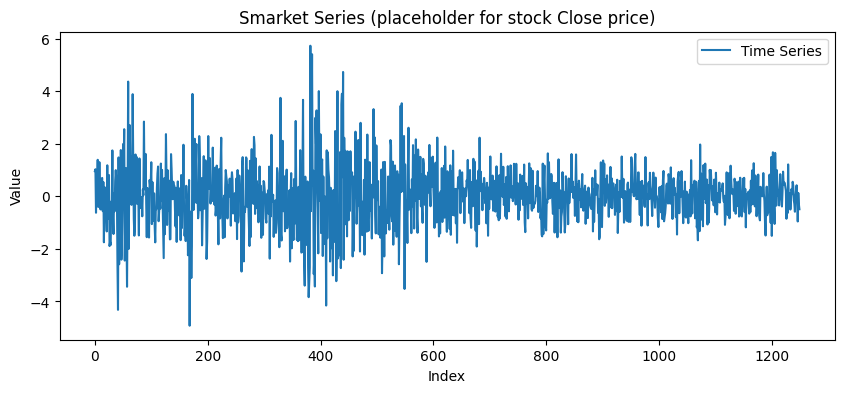

2025-07-29 05:07:07.649855: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.0577
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0147
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0123
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0132
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0127
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0145
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0134
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0123
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0125
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0138
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


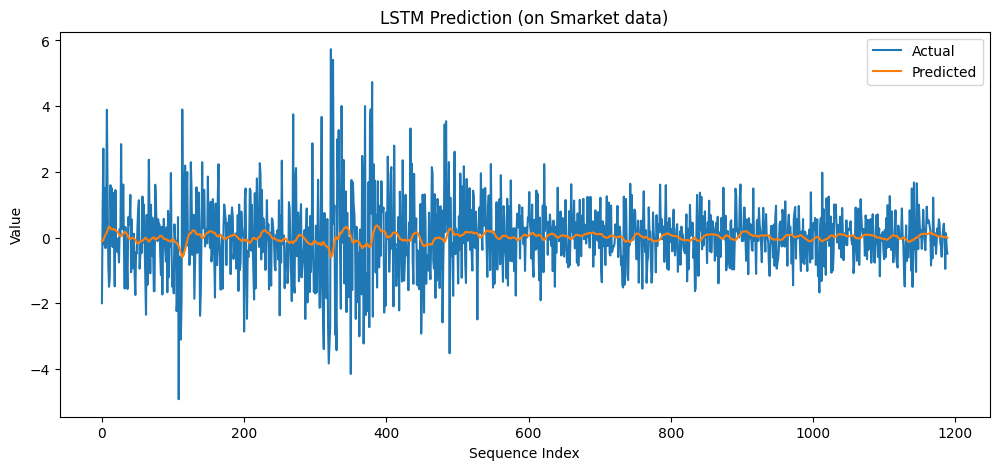

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


NameError: name 'train_size' is not defined

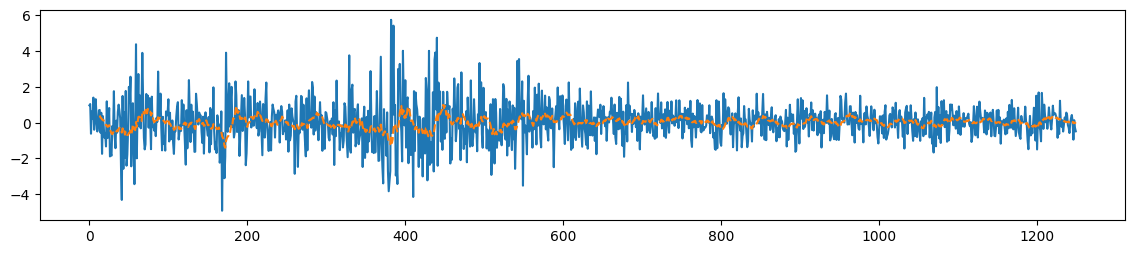

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 📥 Load CSV (change folder name accordingly)
data = pd.read_csv('/kaggle/input/market/Smarket.csv')  # Adjust to your path

# Check its columns
print(data.head())
print("\nColumns:", data.columns)

# We need just the 'Volume' or other numerical column to treat like 'Close'
# Here we use 'Today' column as placeholder
data = data[['Today']].rename(columns={'Today':'Close'})
print("\nUsing column for model:\n", data.head())

# 🧠 Plot stock-like series
plt.figure(figsize=(10,4))
plt.plot(data['Close'], label='Time Series')
plt.title("Smarket Series (placeholder for stock Close price)")
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# 🔁 Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

seq_len = 60
X, y = [], []
for i in range(seq_len, len(scaled)):
    X.append(scaled[i-seq_len:i])
    y.append(scaled[i])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# ⚙️ Build LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_len,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# 🏋️ Train
model.fit(X, y, epochs=10, batch_size=32, verbose=1)

# 📊 Predict & Plot
preds = model.predict(X)
preds = scaler.inverse_transform(preds)
actuals = scaler.inverse_transform(y.reshape(-1, 1))

plt.figure(figsize=(12,5))
plt.plot(actuals, label='Actual')
plt.plot(preds, label='Predicted')
plt.title("LSTM Prediction (on Smarket data)")
plt.xlabel('Sequence Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate Moving Average (14-day)
data['MA_14'] = data['Close'].rolling(window=14).mean()

# Calculate RSI manually (14-day)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Plot everything
plt.figure(figsize=(14, 6))

# Plot 1: Close + Moving Average + Predictions
plt.subplot(2, 1, 1)
plt.plot(data['Close'], label='Actual Close')
plt.plot(data['MA_14'], label='14-day MA', linestyle='--')
plt.plot(range(train_size + look_back, len(data)), y_pred.flatten(), label='Predicted', color='orange')
plt.title('Stock Price, Moving Average, and Prediction')
plt.legend()

# Plot 2: RSI
plt.subplot(2, 1, 2)
plt.plot(data['RSI'], label='RSI (14)', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title('RSI Indicator')
plt.legend()

plt.tight_layout()
plt.show()
# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]
